In [1]:
# imports and config
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

In [2]:
# load and split dataset
DATA_DIR = "/kaggle/input/mendeley-lbc-cervical-cancer"
CATEGORIES = [
    "Negative for Intraepithelial malignancy",
    "Low squamous intra-epithelial lesion",
    "High squamous intra-epithelial lesion",
    "Squamous cell carcinoma"
]

class_to_images = defaultdict(list)
for label, category in enumerate(CATEGORIES):
    for fname in os.listdir(os.path.join(DATA_DIR, category)):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            class_to_images[label].append((os.path.join(DATA_DIR, category, fname), label))

train_data, val_data, test_data = [], [], []
for label, imgs in class_to_images.items():
    train, temp = train_test_split(imgs, test_size=0.3, random_state=42)
    val, test = train_test_split(temp, test_size=0.5, random_state=42)
    train_data += train
    val_data += val
    test_data += test


In [3]:
# transformations
class LBCCytologyDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.data)

# ImageNet normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [4]:
# data augmentation and loaders
train_tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
val_tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_ds = LBCCytologyDataset(train_data, train_tf)
val_ds = LBCCytologyDataset(val_data, val_tf)
test_ds = LBCCytologyDataset(test_data, val_tf)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)

In [5]:
# cnn model w vgg16
def create_model(num_classes=4):
    model = models.vgg16_bn(weights=models.VGG16_BN_Weights.IMAGENET1K_V1)
    for param in model.features.parameters():
        param.requires_grad = False  # Freeze initially
    # Replace classifier
    model.classifier = nn.Sequential(
        nn.Linear(512 * 7 * 7, 4096),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(4096, 1024),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(1024, num_classes)
    )
    return model.to(device)

model = create_model()

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:02<00:00, 230MB/s]


In [6]:
# training
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

def train_model(epochs=25):
    train_loss, val_loss = [], []
    train_acc, val_acc = [], []

    for epoch in range(epochs):
        if epoch == 3:
            for param in model.features[-8:].parameters():
                param.requires_grad = True  # Unfreeze last conv layers

        model.train()
        correct, total, epoch_loss = 0, 0, 0
        for x, y in tqdm(train_dl, desc=f"Epoch {epoch+1}"):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        train_loss.append(epoch_loss / len(train_dl))
        train_acc.append(correct / total)

        # Validation
        model.eval()
        correct, total, val_epoch_loss = 0, 0, 0
        with torch.no_grad():
            for x, y in val_dl:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                val_epoch_loss += loss.item()
                preds = out.argmax(dim=1)
                correct += (preds == y).sum().item()
                total += y.size(0)

        val_loss.append(val_epoch_loss / len(val_dl))
        val_acc.append(correct / total)
        scheduler.step()

        print(f"Epoch {epoch+1}: Train Acc: {train_acc[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}")

    return train_loss, val_loss, train_acc, val_acc

train_loss, val_loss, train_acc, val_acc = train_model()

Epoch 1: 100%|██████████| 21/21 [00:35<00:00,  1.67s/it]


Epoch 1: Train Acc: 0.6994, Val Acc: 0.8819


Epoch 2: 100%|██████████| 21/21 [00:28<00:00,  1.38s/it]


Epoch 2: Train Acc: 0.8542, Val Acc: 0.8958


Epoch 3: 100%|██████████| 21/21 [00:29<00:00,  1.39s/it]


Epoch 3: Train Acc: 0.8824, Val Acc: 0.9097


Epoch 4: 100%|██████████| 21/21 [00:28<00:00,  1.35s/it]


Epoch 4: Train Acc: 0.9062, Val Acc: 0.9028


Epoch 5: 100%|██████████| 21/21 [00:28<00:00,  1.36s/it]


Epoch 5: Train Acc: 0.9048, Val Acc: 0.9514


Epoch 6: 100%|██████████| 21/21 [00:28<00:00,  1.34s/it]


Epoch 6: Train Acc: 0.9360, Val Acc: 0.9583


Epoch 7: 100%|██████████| 21/21 [00:28<00:00,  1.36s/it]


Epoch 7: Train Acc: 0.9464, Val Acc: 0.9583


Epoch 8: 100%|██████████| 21/21 [00:28<00:00,  1.36s/it]


Epoch 8: Train Acc: 0.9583, Val Acc: 0.9722


Epoch 9: 100%|██████████| 21/21 [00:27<00:00,  1.33s/it]


Epoch 9: Train Acc: 0.9583, Val Acc: 0.9653


Epoch 10: 100%|██████████| 21/21 [00:28<00:00,  1.35s/it]


Epoch 10: Train Acc: 0.9643, Val Acc: 0.9653


Epoch 11: 100%|██████████| 21/21 [00:27<00:00,  1.33s/it]


Epoch 11: Train Acc: 0.9598, Val Acc: 0.9722


Epoch 12: 100%|██████████| 21/21 [00:28<00:00,  1.35s/it]


Epoch 12: Train Acc: 0.9583, Val Acc: 0.9792


Epoch 13: 100%|██████████| 21/21 [00:28<00:00,  1.35s/it]


Epoch 13: Train Acc: 0.9554, Val Acc: 0.9792


Epoch 14: 100%|██████████| 21/21 [00:28<00:00,  1.36s/it]


Epoch 14: Train Acc: 0.9524, Val Acc: 0.9861


Epoch 15: 100%|██████████| 21/21 [00:28<00:00,  1.35s/it]


Epoch 15: Train Acc: 0.9747, Val Acc: 0.9931


Epoch 16: 100%|██████████| 21/21 [00:28<00:00,  1.34s/it]


Epoch 16: Train Acc: 0.9717, Val Acc: 0.9861


Epoch 17: 100%|██████████| 21/21 [00:28<00:00,  1.34s/it]


Epoch 17: Train Acc: 0.9643, Val Acc: 0.9583


Epoch 18: 100%|██████████| 21/21 [00:28<00:00,  1.34s/it]


Epoch 18: Train Acc: 0.9420, Val Acc: 0.9722


Epoch 19: 100%|██████████| 21/21 [00:28<00:00,  1.35s/it]


Epoch 19: Train Acc: 0.9524, Val Acc: 0.9931


Epoch 20: 100%|██████████| 21/21 [00:28<00:00,  1.37s/it]


Epoch 20: Train Acc: 0.9673, Val Acc: 0.9931


Epoch 21: 100%|██████████| 21/21 [00:28<00:00,  1.37s/it]


Epoch 21: Train Acc: 0.9658, Val Acc: 0.9931


Epoch 22: 100%|██████████| 21/21 [00:28<00:00,  1.37s/it]


Epoch 22: Train Acc: 0.9762, Val Acc: 1.0000


Epoch 23: 100%|██████████| 21/21 [00:29<00:00,  1.40s/it]


Epoch 23: Train Acc: 0.9673, Val Acc: 1.0000


Epoch 24: 100%|██████████| 21/21 [00:29<00:00,  1.43s/it]


Epoch 24: Train Acc: 0.9628, Val Acc: 0.9931


Epoch 25: 100%|██████████| 21/21 [00:30<00:00,  1.44s/it]


Epoch 25: Train Acc: 0.9836, Val Acc: 1.0000


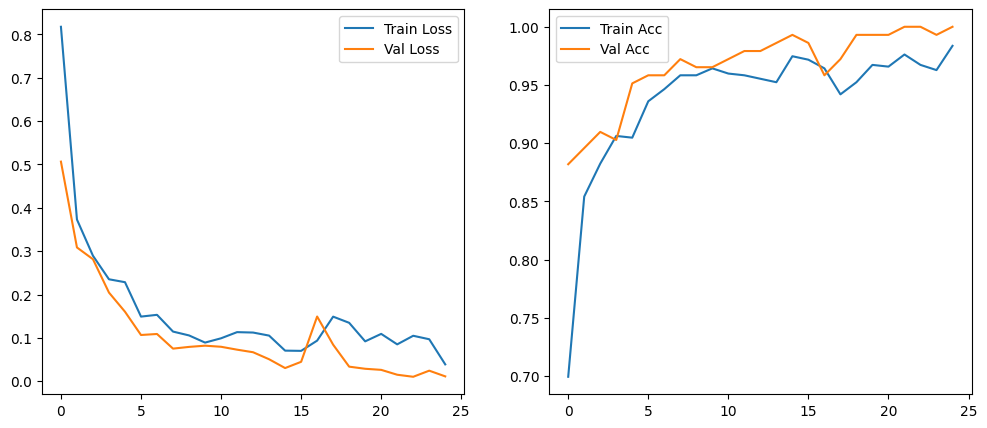

In [7]:
# plot results
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(train_acc, label="Train Acc")
plt.plot(val_acc, label="Val Acc")
plt.legend()
plt.show()

Classification Report:
                                         precision    recall  f1-score   support

Negative for Intraepithelial malignancy       1.00      1.00      1.00        92
   Low squamous intra-epithelial lesion       1.00      1.00      1.00        17
  High squamous intra-epithelial lesion       1.00      1.00      1.00        25
                Squamous cell carcinoma       1.00      1.00      1.00        12

                               accuracy                           1.00       146
                              macro avg       1.00      1.00      1.00       146
                           weighted avg       1.00      1.00      1.00       146



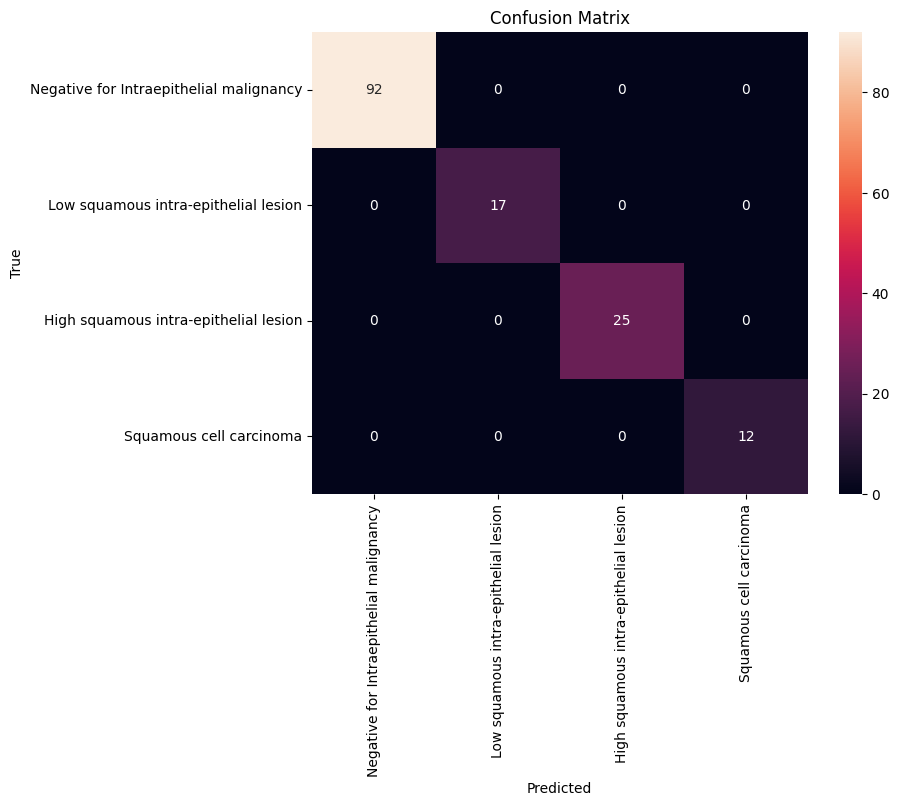

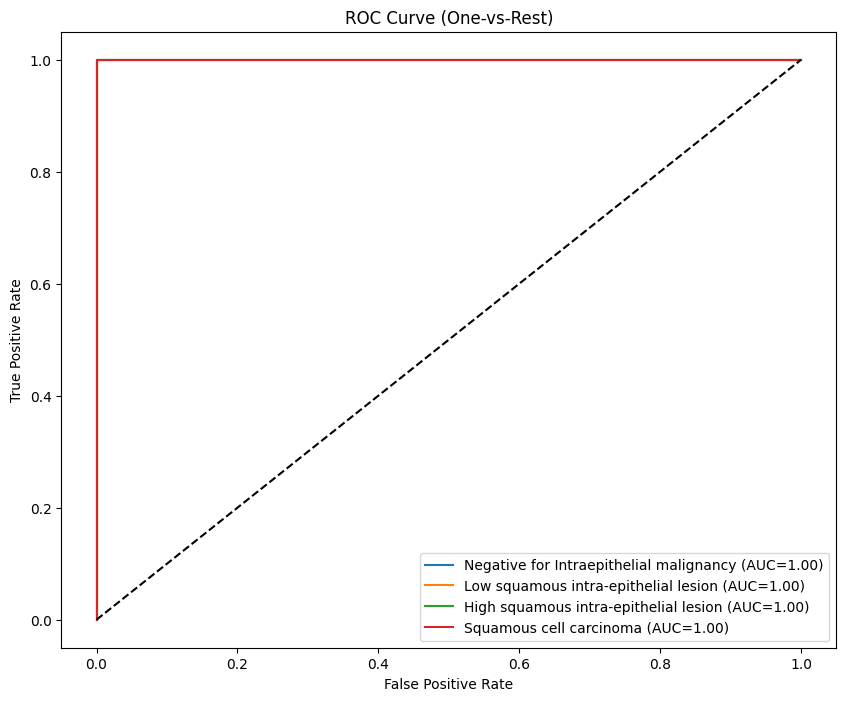

In [8]:
def evaluate(model, loader):
    model.eval()
    y_true, y_pred, y_probs = [], [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            probs = F.softmax(out, dim=1)
            y_true += y.cpu().tolist()
            y_pred += out.argmax(dim=1).cpu().tolist()
            y_probs += probs.cpu().tolist()
    return np.array(y_true), np.array(y_pred), np.array(y_probs)

y_true, y_pred, y_probs = evaluate(model, test_dl)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=CATEGORIES))

plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d",
            xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

plt.figure(figsize=(10,8))
for i in range(4):
    fpr, tpr, _ = roc_curve(y_true == i, y_probs[:, i])
    auc = roc_auc_score(y_true == i, y_probs[:, i])
    plt.plot(fpr, tpr, label=f"{CATEGORIES[i]} (AUC={auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.legend()
plt.title("ROC Curve (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()